In [2]:
### Data Collection
import pandas_datareader as pdr
key=""

In [3]:
df = pdr.get_data_tiingo('TSLA', api_key=key)

In [4]:
df.to_csv('TSLA.csv')

In [7]:
df.shape

(1259, 12)

In [8]:
df.head()

close    high  ...  divCash  splitFactor
symbol date                                       ...                      
TSLA   2015-06-22 00:00:00+00:00  259.79  264.40  ...      0.0          1.0
       2015-06-23 00:00:00+00:00  267.67  268.00  ...      0.0          1.0
       2015-06-24 00:00:00+00:00  265.17  267.35  ...      0.0          1.0
       2015-06-25 00:00:00+00:00  268.79  271.41  ...      0.0          1.0
       2015-06-26 00:00:00+00:00  267.09  269.11  ...      0.0          1.0

[5 rows x 12 columns]

In [9]:
df.tail()

close     high  ...  divCash  splitFactor
symbol date                                         ...                      
TSLA   2020-06-15 00:00:00+00:00   990.90   998.84  ...      0.0          1.0
       2020-06-16 00:00:00+00:00   982.13  1012.88  ...      0.0          1.0
       2020-06-17 00:00:00+00:00   991.79  1005.00  ...      0.0          1.0
       2020-06-18 00:00:00+00:00  1003.96  1019.20  ...      0.0          1.0
       2020-06-19 00:00:00+00:00  1000.90  1015.97  ...      0.0          1.0

[5 rows x 12 columns]

In [10]:
df_f=df.reset_index()['close']

In [11]:
df_f.head()

0    259.79
1    267.67
2    265.17
3    268.79
4    267.09
Name: close, dtype: float64

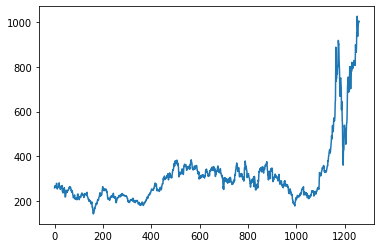

In [12]:
import matplotlib.pyplot as plt
plt.plot(df_f)

Transform the data:

In [13]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df_f=scaler.fit_transform(np.array(df_f).reshape(-1,1))

In [15]:
df_f

array([[0.13174794],
       [0.14068847],
       [0.137852  ],
       ...,
       [0.96226372],
       [0.97607161],
       [0.97259979]])

Test and train Split:

In [17]:

##splitting dataset into train and test split
training_size=int(len(df_f)*0.70)
test_size=len(df_f)-training_size
train_data,test_data=df_f[0:training_size,:],df_f[training_size:len(df_f),:1]

In [18]:
training_size,test_size

(881, 378)

In [19]:

# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [33]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [34]:
print(X_train.shape), print(y_train.shape)

(780, 100)
(780,)


(None, None)

In [35]:
print(X_test.shape), print(ytest.shape)

(277, 100)
(277,)


(None, None)

In [36]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [37]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [38]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [39]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_7 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 3s 237ms/step - loss: 0.0083 - val_loss: 0.0707
Epoch 2/100
13/13 [==============================] - 2s 176ms/step - loss: 0.0024 - val_loss: 0.0323
Epoch 3/100
13/13 [==============================] - 2s 177ms/step - loss: 0.0011 - val_loss: 0.0158
Epoch 4/100
13/13 [==============================] - 2s 184ms/step - loss: 7.0548e-04 - val_loss: 0.0113
Epoch 5/100
13/13 [==============================] - 2s 181ms/step - loss: 6.5491e-04 - val_loss: 0.0131
Epoch 6/100
13/13 [==============================] - 2s 179ms/step - loss: 6.3884e-04 - val_loss: 0.0123
Epoch 7/100
13/13 [==============================] - 2s 181ms/step - loss: 6.0014e-04 - val_loss: 0.0121
Epoch 8/100
13/13 [==============================] - 2s 184ms/step - loss: 5.9588e-04 - val_loss: 0.0117
Epoch 9/100
13/13 [==============================] - 2s 178ms/step - loss: 5.5612e-04 - val_loss: 0.0111
Epoch 10/100
13/13 [==============================] - 2s 180ms/step

In [41]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [42]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [43]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

289.24063429056736

In [44]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

478.0820197233367

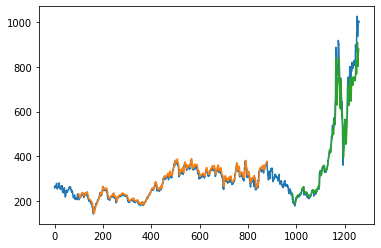

In [50]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df_f)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df_f)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df_f)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df_f))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [54]:
len(test_data)

378

In [55]:
x_input=test_data[278:].reshape(1,-1)
x_input.shape

(1, 100)

In [56]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [57]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.8306094]
101
1 day input [0.56404729 0.57512083 0.72197009 0.8434387  0.67057342 0.68675259
 0.68574281 0.71207652 0.71559373 0.70754952 0.74920012 0.74469582
 0.81092151 0.87788468 0.85745082 0.8592548  0.78299939 0.74455967
 0.72060859 0.60737707 0.59488529 0.68069391 0.68283828 0.68736527
 0.65904604 0.63515169 0.52682158 0.56917561 0.55658172 0.47298555
 0.45718078 0.34196374 0.32509247 0.24682884 0.32218793 0.32206313
 0.32973292 0.40995938 0.4488189  0.43623636 0.42057909 0.40670312
 0.43151649 0.38336472 0.35262883 0.38160612 0.42271211 0.45585332
 0.45969956 0.48711112 0.57555198 0.64242438 0.66504799 0.6824979
 0.69234609 0.68380267 0.61613606 0.66763485 0.63759105 0.65973814
 0.74324355 0.70962581 0.74524042 0.72410311 0.63270099 0.70062856
 0.70859334 0.72489732 0.72201548 0.76669541 0.75747124 0.75533822
 0.73440514 0.74843995 0.74372008 0.76012617 0.7537498  0.76231591
 0.77597631 0.76381357 0.76607139 0.76761442 0.75125372 0.78437223
 0.85596451 0.83719848 0.8387869  0

In [58]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [59]:
df_f.shape

(1259, 1)

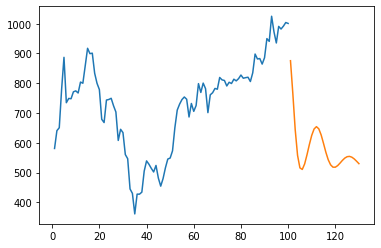

In [61]:
plt.plot(day_new,scaler.inverse_transform(df_f[1159:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

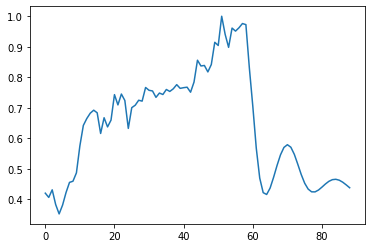

In [62]:
df3=df_f.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

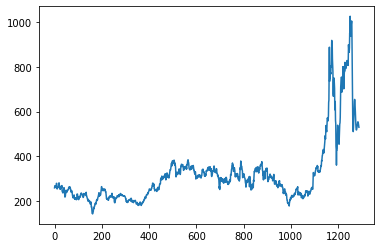

In [63]:
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)

Reference :
https://machinelearningmastery.com/time-series-prediction-with-deep-learning-in-python-with-keras/